## Group Number: 9
## Names: Aaryan, Sanika, Neelakshi 
## Project Name: VPN Classification

In [1]:
import csv
import pandas as pd

import ast

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN

In [2]:
# Install Kaggle library
!pip install kaggle

# Upload your Kaggle API key (kaggle.json) file
from google.colab import files
files.upload()

# Move the API key to the correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the competition data
!kaggle competitions download -c vpn-classification

# Unzip the downloaded files
!unzip '*.zip'

Saving kaggle.json to kaggle.json
100% 1.44G/1.45G [01:19<00:00, 14.2MB/s]
100% 1.45G/1.45G [01:19<00:00, 19.4MB/s]
Archive:  vpn-classification.zip
  inflating: dataset_v2/samples_submissions.csv  
  inflating: dataset_v2/shodan_df_hashed.csv  
  inflating: dataset_v2/test.csv     
  inflating: dataset_v2/test.parq    
  inflating: dataset_v2/train.csv    
  inflating: dataset_v2/train.parq   


In [ ]:
# Unzip the downloaded files
# !unzip '*.zip'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_parquet("/content/dataset_v2/train.parq")
df.dtypes
df.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum,label
0,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:exploit,0,6466,0
1,2023-07-31 07:17:51+00:00,DE,34011.0,Host Europe GmbH,TR,47721.0,Murat Aktas,http:spam,0,6466,0
2,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:bruteforce,2,4637,0
3,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:spam,2,4637,0
4,2023-07-31 07:17:49+00:00,DE,20886.0,bn:t Blatzheim Networks Telecom GmbH,DE,51167.0,Contabo GmbH,http:exploit,2,4637,0


In [4]:
#EDA

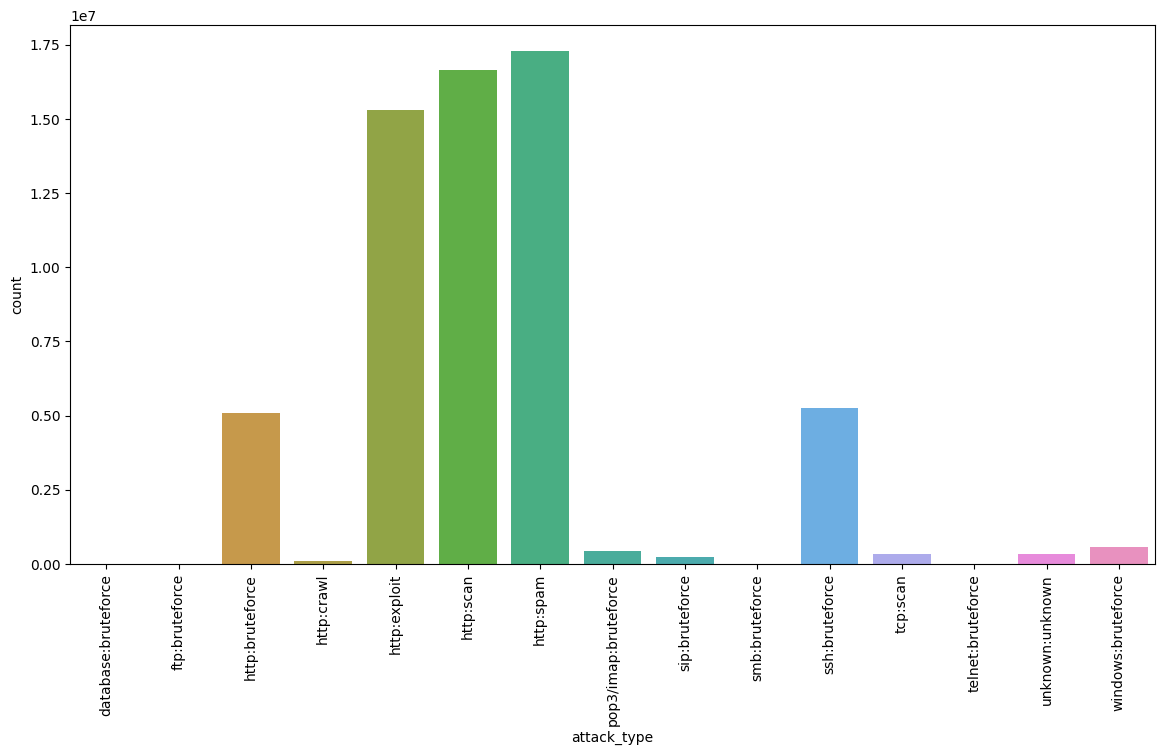

In [5]:
_ = plt.figure(figsize=(14, 7))
_ = sns.countplot(x=df["attack_type"])
_ = plt.xticks(rotation=90)
plt.show()

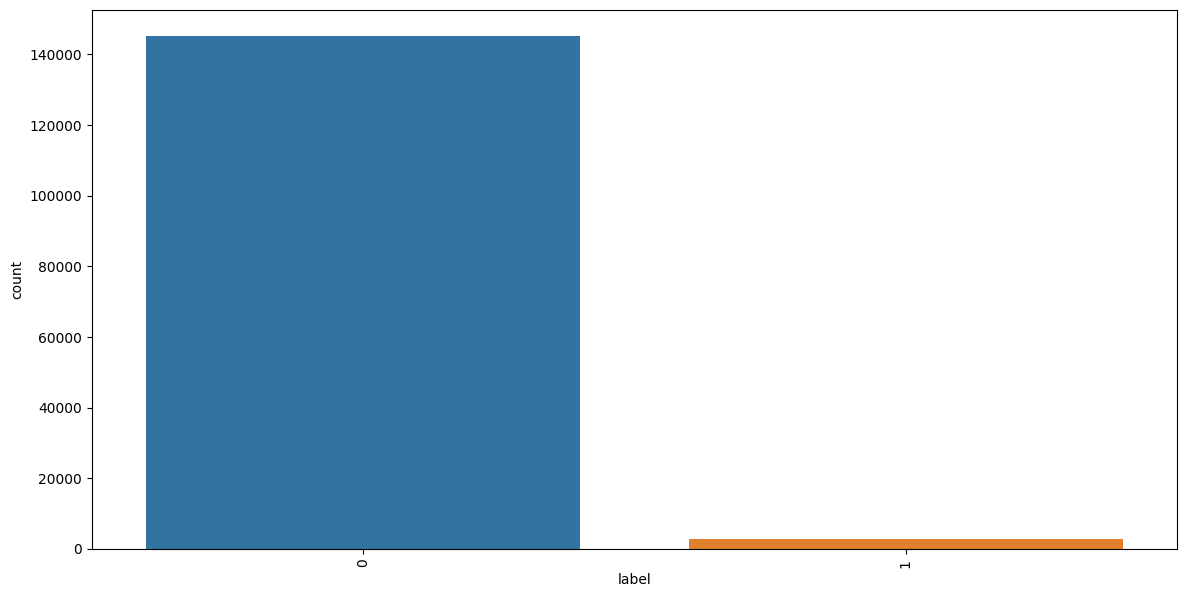

In [6]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=df.groupby("attacker_ip_enum")["label"].max())
_ = plt.xticks(rotation=90)
plt.show()

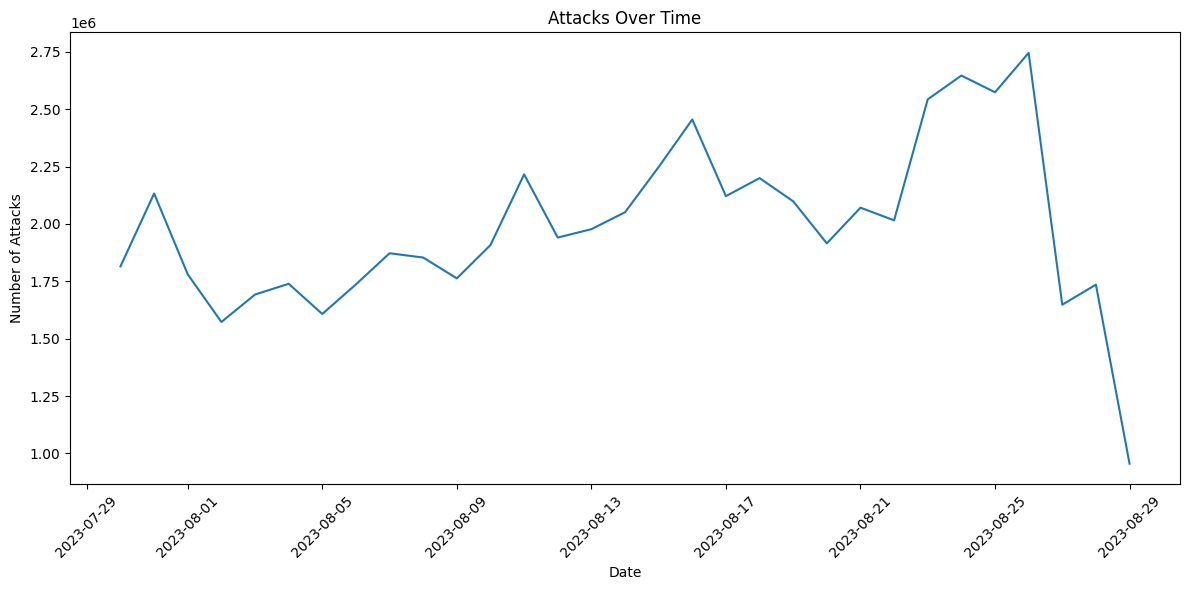

In [7]:
data = df
data['attack_time'] = pd.to_datetime(data['attack_time'])
data['attack_date'] = data['attack_time'].dt.date

plt.figure(figsize=(12, 6))
data.groupby('attack_date').size().plot()
plt.title('Attacks Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [8]:
df.shape

(61629685, 12)

In [9]:
# df = df.head(1000000)

In [10]:
df.shape

(61629685, 12)

In [11]:
#Feature Engineering

In [12]:
#One-hot attack types¶

In [13]:
attack_types_df = (
    df.attack_type.str.split(":", expand=True)
    .rename(columns={0: "service", 1: "type"})
    .set_index(df["attacker_ip_enum"])
)

In [14]:
one_hot_attack_service_df = pd.get_dummies(
    # Dropping duplicated service before calling get dummies
    attack_types_df.reset_index()
    .drop_duplicates(subset=["attacker_ip_enum", "service"])
    .set_index("attacker_ip_enum")["service"]
    # ,sparse=True
)
one_hot_attack_service_df = one_hot_attack_service_df.groupby("attacker_ip_enum").sum()
# We group by ip_enum and keep only strictly positive values
one_hot_attack_service_df = (one_hot_attack_service_df >= 1).astype(int)
one_hot_attack_service_df.head()

,database,ftp,http,pop3/imap,sip,smb,ssh,tcp,telnet,unknown,windows
attacker_ip_enum,,,,,,,,,,,
0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,0


In [15]:
one_hot_attack_types_df = pd.get_dummies(
    attack_types_df["type"],
    # sparse=True
)
one_hot_attack_types_df = one_hot_attack_types_df.groupby("attacker_ip_enum").sum()
# We group by ip_enum and normalized by the number of attack to get a distribyution
one_hot_attack_types_df = one_hot_attack_types_df / one_hot_attack_types_df.sum(
    1
).values.reshape(-1, 1)
one_hot_attack_types_df.head(10)

,bruteforce,crawl,exploit,scan,spam,unknown
attacker_ip_enum,,,,,,
0,0.000000,0.0,0.000000,0.500000,0.500000,0.0
1,0.266667,0.0,0.466667,0.033333,0.233333,0.0
2,0.000000,0.0,0.000000,0.931034,0.068966,0.0
3,0.080000,0.0,0.600000,0.040000,0.280000,0.0
4,0.235294,0.0,0.455882,0.058824,0.250000,0.0
6,0.000000,0.0,0.021739,0.847826,0.130435,0.0
8,0.235294,0.0,0.470588,0.058824,0.235294,0.0
9,0.250000,0.0,0.500000,0.000000,0.250000,0.0
11,0.006250,0.0,0.006250,0.793750,0.193750,0.0


In [16]:
#Open ports Feature¶

In [17]:
REFERENCE_PORTS = set(("22", "80", "443", "7777"))


def extract_port_numbers(value: dict):
    return set(key.split("/")[0] for key in value.keys())

shodan_df =pd.read_csv("/content/dataset_v2/shodan_df_hashed.csv",dtype={"attacker_ip_enum": "int32"},index_col="attacker_ip_enum",)

shodan_df["shodan_info"] = shodan_df["shodan_info"].map(ast.literal_eval)#str to dict
shodan_df["shodan_open_ports"] = shodan_df["shodan_info"].map(extract_port_numbers)

In [18]:
open_ports_count = shodan_df["shodan_open_ports"].map(len).rename("open_ports_count")
# We select the reference port by doing a set intersection
reference_ports_df = shodan_df["shodan_open_ports"].map(lambda x: REFERENCE_PORTS & x)

one_hot_reference_ports_df = pd.get_dummies(reference_ports_df.explode(), prefix="port")
# Aggregate the dummies by IP
one_hot_reference_ports_df = one_hot_reference_ports_df.groupby(
    "attacker_ip_enum"
).sum()
# Final feature for port: count and one hot table of reference port
ports_features_df = pd.concat([one_hot_reference_ports_df, open_ports_count], axis=1)
# Checking results
ports_features_df[(ports_features_df > 0).any(axis=1)].head()

,port_22,port_443,port_7777,port_80,open_ports_count
attacker_ip_enum,,,,,
5,0,0,0,1,2
7,1,1,0,1,6
13,0,0,0,1,6
18,1,0,0,0,1
24,0,1,0,1,15


In [19]:
#Feature Aggregation

In [20]:
# We create a df label df which contains one row per attacker IP
label_df = df.drop_duplicates(["attacker_ip_enum", "label"]).set_index(
    "attacker_ip_enum"
)["label"]

dataset = pd.concat(
    [
        one_hot_attack_types_df,
        one_hot_attack_service_df,
        ports_features_df,
        label_df,
    ],
    axis=1,
    join="inner",
)


In [21]:
dataset.shape

(148259, 23)

In [22]:
dataset.head()

,bruteforce,crawl,exploit,scan,spam,unknown,database,ftp,http,pop3/imap,...,tcp,telnet,unknown,windows,port_22,port_443,port_7777,port_80,open_ports_count,label
attacker_ip_enum,,,,,,,,,,,,,,,,,,,,,
0,0.000000,0.0,0.000000,0.500000,0.500000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.266667,0.0,0.466667,0.033333,0.233333,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.000000,0.0,0.000000,0.931034,0.068966,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.080000,0.0,0.600000,0.040000,0.280000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.235294,0.0,0.455882,0.058824,0.250000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
dataset['label'].value_counts()

0    145369
1      2890
Name: label, dtype: int64

In [24]:
# dataset.to_csv("dataset.csv", index = False)
# files.download('dataset.csv')

In [25]:
#Upsampling and Downsampling

In [26]:
from imblearn.over_sampling import ADASYN
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split

In [27]:
train, test = train_test_split(dataset, test_size=0.3)

In [28]:
X_train_raw = train.drop(["label"], axis=1)
y_train_raw = train["label"]
X_test_raw = test.drop(["label"], axis=1)
y_test_raw = test["label"]

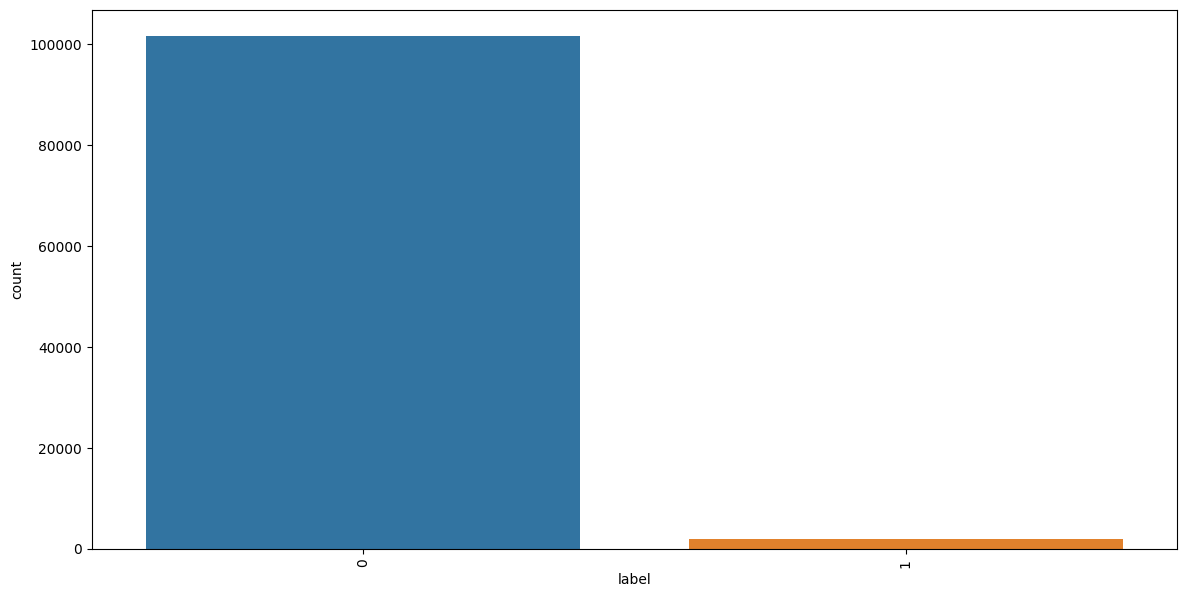

In [29]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=train["label"])
_ = plt.xticks(rotation=90)
plt.show()

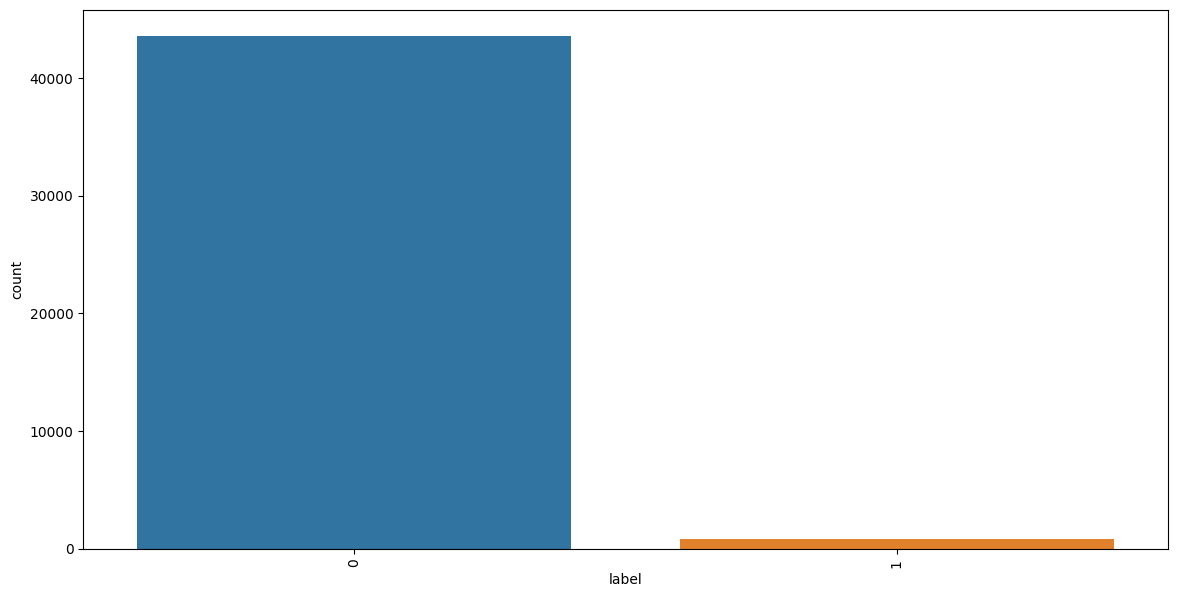

In [30]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=test["label"])
_ = plt.xticks(rotation=90)
plt.show()

In [31]:

# ros = RandomOverSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = ros.fit_resample(X_train_raw, y_train_raw)

In [32]:
# #Alternatively, you can use random undersampling
# rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

In [33]:
# Or use a combination of over- and undersampling (SMOTEENN)
# smote_enn = SMOTEENN(sampling_strategy='auto', random_state=42)
# X_train_resampled, y_train_resampled = smote_enn.fit_resample(X_train, y_train)


In [34]:
under = RandomUnderSampler(replacement=False)# randomly picks samples, 
over = ADASYN(n_neighbors = 10, n_jobs=-1)

In [68]:
X_train, y_train = over.fit_resample(X_train_raw, y_train_raw)
X_test, y_test = under.fit_resample(X_test_raw, y_test_raw)

/usr/local/lib/python3.10/dist-packages/imblearn/over_sampling/_adasyn.py:156: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [36]:
result_df = pd.merge(X_train, y_train, left_index=True, right_index=True)

In [37]:
result_test_df = pd.merge(X_test, y_test, left_index=True, right_index=True)

In [38]:
result_df

,bruteforce,crawl,exploit,scan,spam,unknown,database,ftp,http,pop3/imap,...,tcp,telnet,unknown,windows,port_22,port_443,port_7777,port_80,open_ports_count,label
0,0.166667,0.0,0.555556,0.000000,0.277778,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0,0,0,0,...,0,0,0,0,0,1,0,1,3,0
2,0.200000,0.0,0.375000,0.125000,0.300000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,0.000000,1.000000,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203158,0.000000,0.0,0.322513,0.218237,0.459251,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,10,1
203159,0.000000,0.0,0.323364,0.220532,0.456105,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,10,1
203160,0.000000,0.0,0.324770,0.219937,0.455293,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,10,1
203161,0.000000,0.0,0.323770,0.218722,0.457508,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,10,1


In [39]:
result_test_df

,bruteforce,crawl,exploit,scan,spam,unknown,database,ftp,http,pop3/imap,...,tcp,telnet,unknown,windows,port_22,port_443,port_7777,port_80,open_ports_count,label
0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.151515,0.000000,0.484848,0.060606,0.303030,0.000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.219512,0.000000,0.463415,0.048780,0.268293,0.000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.000000,0.000000,0.904762,0.095238,0.000,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.000000,0.000000,0.500000,0.500000,0.000,0,0,1,0,...,0,0,0,0,0,0,0,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1749,0.000000,0.000000,0.038462,0.538462,0.423077,0.000,0,0,1,0,...,0,0,0,0,0,0,0,0,2,1
1750,0.088889,0.044444,0.344444,0.211111,0.311111,0.000,0,0,1,0,...,0,0,0,0,0,0,1,1,4,1
1751,0.055000,0.000000,0.365000,0.257500,0.317500,0.005,0,0,1,0,...,0,0,1,0,0,1,0,1,2,1
1752,0.194444,0.034722,0.361111,0.152778,0.256944,0.000,0,0,1,0,...,0,0,0,0,0,0,0,1,2,1


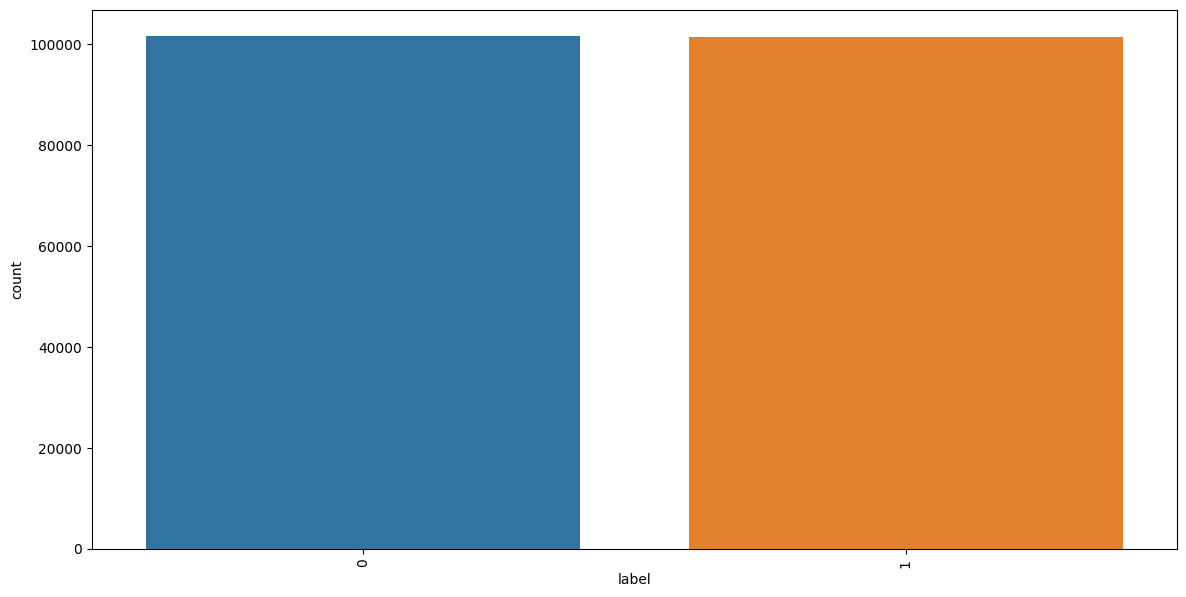

In [40]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=result_df["label"])
_ = plt.xticks(rotation=90)
plt.show()

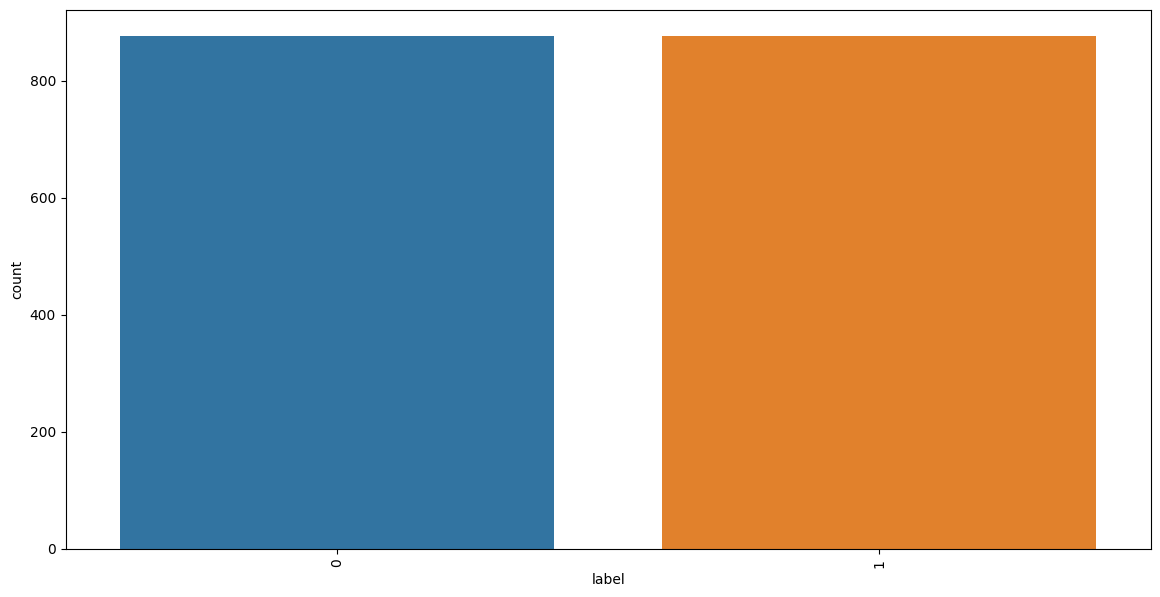

In [41]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=result_test_df["label"])
_ = plt.xticks(rotation=90)
plt.show()

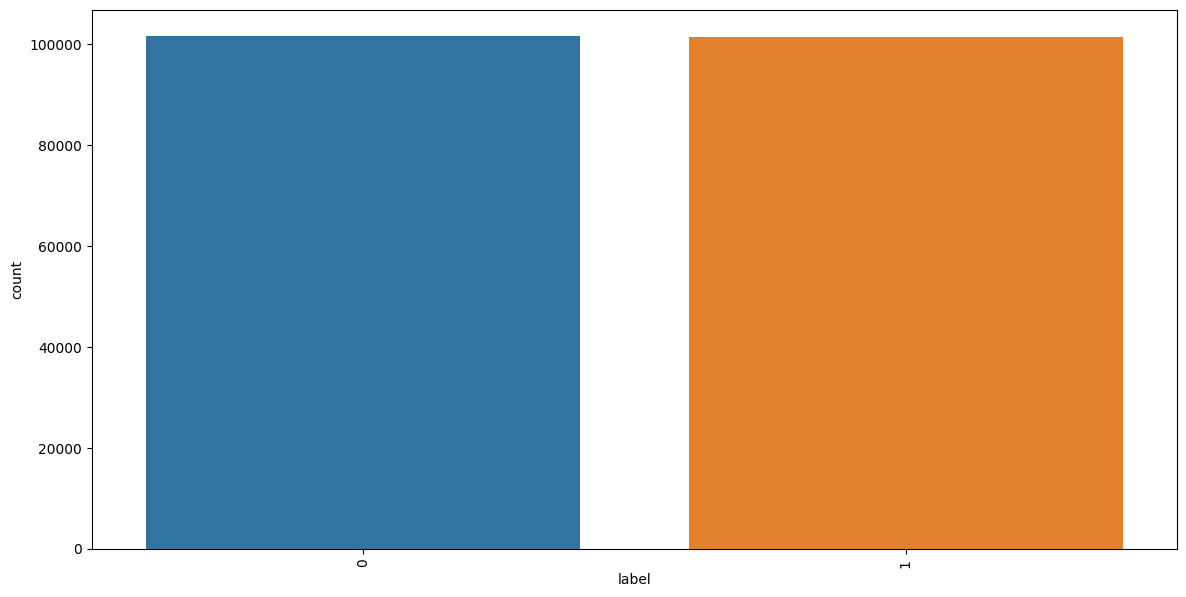

In [42]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=result_df["label"])
_ = plt.xticks(rotation=90)
plt.show()

In [43]:
# X_train, y_train = X_train_resampled, y_train_resampled
# X_test, y_test = X_test_raw, y_test_raw

In [44]:
#Model training

In [45]:
from sklearn.preprocessing import StandardScaler

In [46]:
X_train.head()

,bruteforce,crawl,exploit,scan,spam,unknown,database,ftp,http,pop3/imap,...,ssh,tcp,telnet,unknown,windows,port_22,port_443,port_7777,port_80,open_ports_count
0,0.166667,0.0,0.555556,0.000,0.277778,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,1.000000,0.0,0.000000,0.000,0.000000,0.0,0,0,0,0,...,1,0,0,0,0,0,1,0,1,3
2,0.200000,0.0,0.375000,0.125,0.300000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,0.000000,1.000,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,0.000000,1.000,0.000000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
X_train.shape

(203163, 22)

In [48]:
y_train.shape

(203163,)

In [49]:
y_train.value_counts()

0    101768
1    101395
Name: label, dtype: int64

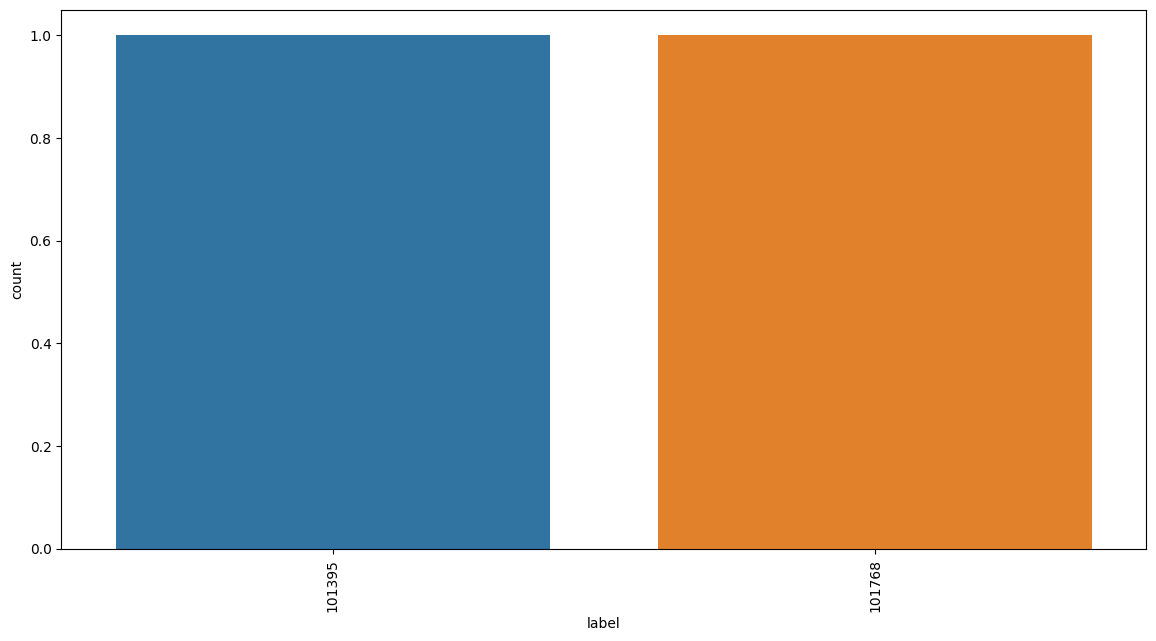

In [50]:
_ = plt.figure(figsize=(14, 7))
# Counting the number of labels for each IP (hence the groupby)
_ = sns.countplot(x=y_train.value_counts())
_ = plt.xticks(rotation=90)
plt.show()

In [51]:
X_test.shape

(1754, 22)

In [52]:
y_test.value_counts()

0    877
1    877
Name: label, dtype: int64

In [53]:
col = X_train.columns

In [54]:
col

Index(['bruteforce', 'crawl', 'exploit', 'scan', 'spam', 'unknown', 'database',
       'ftp', 'http', 'pop3/imap', 'sip', 'smb', 'ssh', 'tcp', 'telnet',
       'unknown', 'windows', 'port_22', 'port_443', 'port_7777', 'port_80',
       'open_ports_count'],
      dtype='object')

In [55]:
X_test.head()

,bruteforce,crawl,exploit,scan,spam,unknown,database,ftp,http,pop3/imap,...,ssh,tcp,telnet,unknown,windows,port_22,port_443,port_7777,port_80,open_ports_count
0,1.000000,0.0,0.000000,0.000000,0.000000,0.0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.151515,0.0,0.484848,0.060606,0.303030,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,0.219512,0.0,0.463415,0.048780,0.268293,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0.000000,0.0,0.000000,0.904762,0.095238,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,0.000000,0.0,0.000000,0.500000,0.500000,0.0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,2


In [56]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [57]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

In [58]:
parameters = {
    "max_depth": [None, 10, 20],
    "max_features": ["sqrt", None],
    "class_weight": ["balanced", None],
}
est = RandomForestClassifier()
clf = GridSearchCV(est, parameters, scoring="f1", n_jobs=-1)

In [51]:
start_time

1701630058.9078615

In [52]:
clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [None, 10, 20],
                         'max_features': ['sqrt', None]},
             scoring='f1')

In [55]:
clf.best_params_

{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt'}

In [56]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head(10)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_class_weight,param_max_depth,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
4,47.231101,2.130961,1.118217,0.255389,balanced,20,sqrt,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.957549,0.956223,0.956116,0.955009,0.966360,0.958252,0.004134,1
6,50.861143,2.147152,1.255863,0.284852,None,None,sqrt,"{'class_weight': None, 'max_depth': None, 'max...",0.955729,0.956856,0.957122,0.954822,0.963503,0.957607,0.003061,2
0,53.135247,3.137107,1.179270,0.318333,balanced,None,sqrt,"{'class_weight': 'balanced', 'max_depth': None...",0.957474,0.956457,0.956502,0.953683,0.963416,0.957507,0.003214,3
10,39.951620,4.481538,0.917944,0.258722,None,20,sqrt,"{'class_weight': None, 'max_depth': 20, 'max_f...",0.955361,0.955677,0.955760,0.954372,0.965177,0.957269,0.003984,4
11,171.749912,27.696311,0.941497,0.259361,None,20,None,"{'class_weight': None, 'max_depth': 20, 'max_f...",0.956130,0.955816,0.955287,0.952928,0.962883,0.956609,0.003332,5
5,188.643887,6.599883,0.986452,0.197360,balanced,20,None,"{'class_weight': 'balanced', 'max_depth': 20, ...",0.954355,0.956564,0.954806,0.953142,0.962399,0.956253,0.003263,6
1,209.159199,9.197967,0.892693,0.141550,balanced,None,None,"{'class_weight': 'balanced', 'max_depth': None...",0.954758,0.955991,0.954771,0.951365,0.960626,0.955502,0.002990,7
7,202.682705,25.751889,1.194958,0.161844,None,None,None,"{'class_weight': None, 'max_depth': None, 'max...",0.954345,0.956117,0.954861,0.951869,0.960108,0.955460,0.002703,8
3,101.151492,12.581252,0.552415,0.176708,balanced,10,None,"{'class_weight': 'balanced', 'max_depth': 10, ...",0.942322,0.946355,0.940541,0.938691,0.948266,0.943235,0.003572,9
9,127.766442,2.055839,0.615429,0.124410,None,10,None,"{'class_weight': None, 'max_depth': 10, 'max_f...",0.942042,0.946138,0.940798,0.937408,0.949122,0.943102,0.004106,10


In [57]:
y_pred = clf.predict(X_test)

In [58]:
f1_score(y_pred=y_pred, y_true=y_test)

0.9363336992316137

In [59]:
from sklearn.metrics import accuracy_score
accuracy_score(y_pred=y_pred, y_true=y_test)

0.9348314606741573

In [64]:
print("Classification Report:")
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_test, y_pred))
conf_matrix = confusion_matrix(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.91      0.93       890
           1       0.92      0.96      0.94       890

    accuracy                           0.93      1780
   macro avg       0.94      0.93      0.93      1780
weighted avg       0.94      0.93      0.93      1780



In [65]:
conf_matrix

array([[811,  79],
       [ 37, 853]])

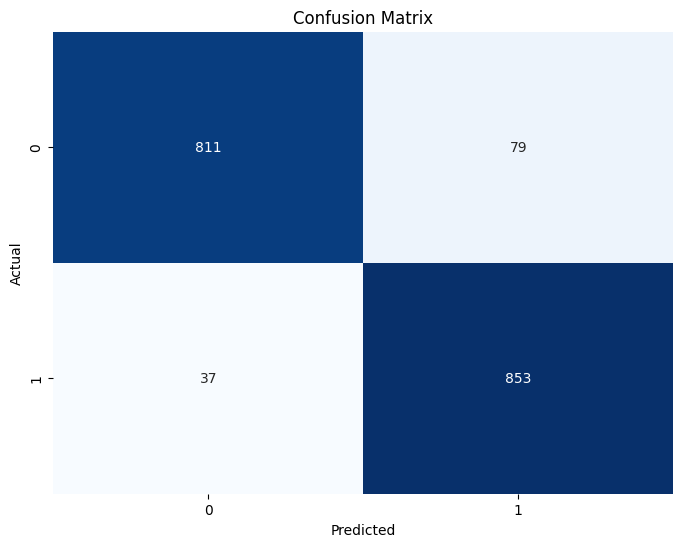

In [66]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [61]:
# import pickle

# # Save the model to a file
# with open('trained_model.pkl', 'wb') as file:
#     pickle.dump(clf, file)

In [62]:
# files.download('trained_model.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [61]:
import pickle
with open('trained_model.pkl', 'rb') as file:
    clf = pickle.load(file)

In [62]:
clf.best_params_

{'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt'}

In [63]:
model = RandomForestClassifier(n_jobs=-1, **clf.best_params_)
model.fit(sc.transform(dataset.drop(["label"], axis=1)), dataset["label"])

RandomForestClassifier(class_weight='balanced', max_depth=20, n_jobs=-1)

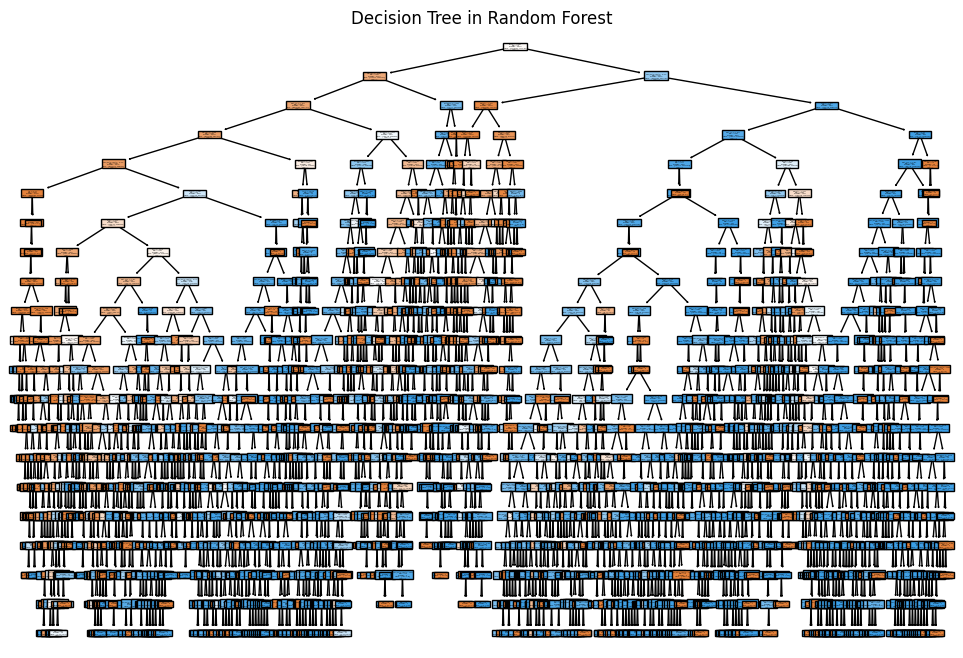

In [69]:
# Visualize one of the trees (e.g., the first tree in the forest)
from sklearn.tree import plot_tree
plt.figure(figsize=(12, 8))
plot_tree(model.estimators_[0], feature_names=X_train.columns, class_names="Label", filled=True)
plt.title("Decision Tree in Random Forest")
plt.show()

In [74]:
from sklearn.tree import export_graphviz
dot_data = export_graphviz(model.estimators_[0], out_file=None, feature_names=X_train.columns,
                           class_names="Label", filled=True, rounded=True)


In [76]:
import graphviz
graph = graphviz.Source(dot_data)
graph.render(filename='random_forest_tree', format='png', cleanup=True)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.338261 to fit


'random_forest_tree.png'

In [64]:
#Testing

In [67]:
df = pd.read_parquet("/content/dataset_v2/test.parq")
df.head()

,attack_time,watcher_country,watcher_as_num,watcher_as_name,attacker_country,attacker_as_num,attacker_as_name,attack_type,watcher_uuid_enum,attacker_ip_enum
0,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:spam,1,7696
1,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:exploit,1,7696
2,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,1,7696
3,2023-07-31 07:17:58+00:00,US,54641.0,IMH-IAD,IN,14061.0,DIGITALOCEAN-ASN,http:bruteforce,1,7696
4,2023-07-31 07:17:51+00:00,US,396982.0,GOOGLE-CLOUD-PLATFORM,US,53667.0,PONYNET,http:bruteforce,3,7543


In [66]:
df.shape

(18682297, 10)

In [67]:
# df = df.head(10000)

In [68]:
attack_types_df = (
    df.attack_type.str.split(":", expand=True)
    .rename(columns={0: "service", 1: "type"})
    .set_index(df["attacker_ip_enum"])
)

In [69]:
one_hot_attack_service_df = pd.get_dummies(
    # Dropping duplicated service before calling get dummies
    attack_types_df.reset_index()
    .drop_duplicates(subset=["attacker_ip_enum", "service"])
    .set_index("attacker_ip_enum")["service"]
    # ,sparse=True
)
one_hot_attack_service_df = one_hot_attack_service_df.groupby("attacker_ip_enum").sum()
one_hot_attack_service_df = (one_hot_attack_service_df >= 1).astype(int)

In [70]:
one_hot_attack_types_df = pd.get_dummies(
    attack_types_df["type"],
    # sparse=True
)
one_hot_attack_types_df = one_hot_attack_types_df.groupby("attacker_ip_enum").sum()
# We group by ip_enum and normalized by the number of attack to get a distribyution
one_hot_attack_types_df = one_hot_attack_types_df / one_hot_attack_types_df.sum(
    1
).values.reshape(-1, 1)

In [71]:
X_val_df = pd.concat(
    [
        one_hot_attack_types_df,
        one_hot_attack_service_df,
        ports_features_df,
    ],
    axis=1,
    join="inner",
)

In [72]:
one_hot_attack_types_df.columns

Index(['bruteforce', 'crawl', 'exploit', 'scan', 'spam', 'unknown'], dtype='object')

In [73]:
one_hot_attack_service_df.columns

Index(['database', 'ftp', 'http', 'pop3/imap', 'sip', 'smb', 'ssh', 'tcp',
       'telnet', 'unknown', 'windows'],
      dtype='object')

In [74]:
ports_features_df.columns

Index(['port_22', 'port_443', 'port_7777', 'port_80', 'open_ports_count'], dtype='object')

In [75]:
X_val_df.columns

Index(['bruteforce', 'crawl', 'exploit', 'scan', 'spam', 'unknown', 'database',
       'ftp', 'http', 'pop3/imap', 'sip', 'smb', 'ssh', 'tcp', 'telnet',
       'unknown', 'windows', 'port_22', 'port_443', 'port_7777', 'port_80',
       'open_ports_count'],
      dtype='object')

In [76]:
col

Index(['bruteforce', 'crawl', 'exploit', 'scan', 'spam', 'unknown', 'database',
       'ftp', 'http', 'pop3/imap', 'sip', 'smb', 'ssh', 'tcp', 'telnet',
       'unknown', 'windows', 'port_22', 'port_443', 'port_7777', 'port_80',
       'open_ports_count'],
      dtype='object')

In [77]:
# X_val_df = X_val_df.drop(['database', 'ftp', 'smb', 'telnet'], axis = 1)

In [78]:
X_val = sc.transform(X_val_df)

In [79]:
prediction = pd.Series(model.predict(X_val), index=X_val_df.index).rename("prediction")

In [80]:
prediction.to_csv("predictions.csv")

In [79]:
prediction.value_counts()

0    48412
1     1008
Name: prediction, dtype: int64